In [6]:
import QuantLib as ql
import os

import platform

plt = platform.system()
if plt == "Windows":
    os.chdir('C:\\Users\\dduarte\\Documents\\Consulting\\Datsura\\curve_framework')
elif plt == "Linux":
    os.chdir('/home/nhaga/Documents/consulting/datsura/curve_framework/')

from main import curves
from utils import objects, swap_configs, CurveBuilder
import pandas as pd

ql.Settings.instance().evaluationDate

Date(9,11,2020)

In [2]:
fwds = pd.read_excel('../Fwds.xlsx', sheet_name="Sheet3", usecols='C:O', skiprows=3, index_col=0)
fwds = fwds[fwds.columns[1:]].iloc[1:]
fwds

,USD.3M,EUR.1M,EUR.3M,EUR.6M,SEK.3M,CZK.3M,CZK.6M,PLN.3M,PLN.6M,HUF.3M,HUF.6M
2021-03-15,0.215663,-0.553144,-0.530268,-0.502601,-0.0497098,0.321212,0.358787,0.180412,0.207682,0.746357,0.773369
2021-03-22,0.211831,-0.553437,-0.530372,-0.50274,-0.0472367,0.323187,0.36187,0.180522,0.206107,0.745583,0.773721
2021-03-29,0.208987,-0.554587,-0.530016,-0.502977,-0.0454467,0.325201,0.365011,0.180925,0.206141,0.744877,0.776138
2021-04-05,0.206779,-0.556474,-0.529586,-0.503437,-0.0440899,0.327445,0.368922,0.181505,0.207736,0.744563,0.7807
2021-04-12,0.205791,-0.558282,-0.529483,-0.503896,-0.0435103,0.33,0.372767,0.182,0.21,0.745,0.785209
...,...,...,...,...,...,...,...,...,...,...,...
2027-02-15,1.25848,-0.16841,-0.0958646,-0.0560621,0.447457,1.16595,1.28431,1.36879,1.46769,1.73188,1.76789
2027-02-22,1.26142,-0.166436,-0.0929308,-0.0538322,0.449509,1.16588,1.28521,1.37145,1.47042,1.73561,1.77128
2027-03-01,1.2648,-0.163941,-0.0898394,-0.0512984,0.452117,1.16573,1.28634,1.37469,1.47383,1.74023,1.77551
2027-03-08,1.26791,-0.161822,-0.0869908,-0.0490856,0.454696,1.1655,1.28721,1.37726,1.47656,1.74391,1.77888


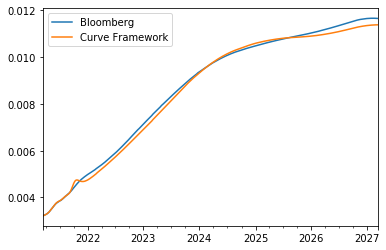

In [4]:
ticker = 'CZK.3M'
res = pd.DataFrame(fwds[ticker]) / 100
res.columns = ['Bloomberg']
crv = curves.get(ticker)

def getFwd(dt):
    tenor = ticker[4:]
    start = ql.Date(str(dt)[:10], '%Y-%m-%d')
    return crv.forwardRate(start, start + ql.Period(tenor), ql.Actual360(), ql.Compounded).rate()
    
res['Curve Framework'] = [*map(lambda x: getFwd(x), res.index)]

res.plot()

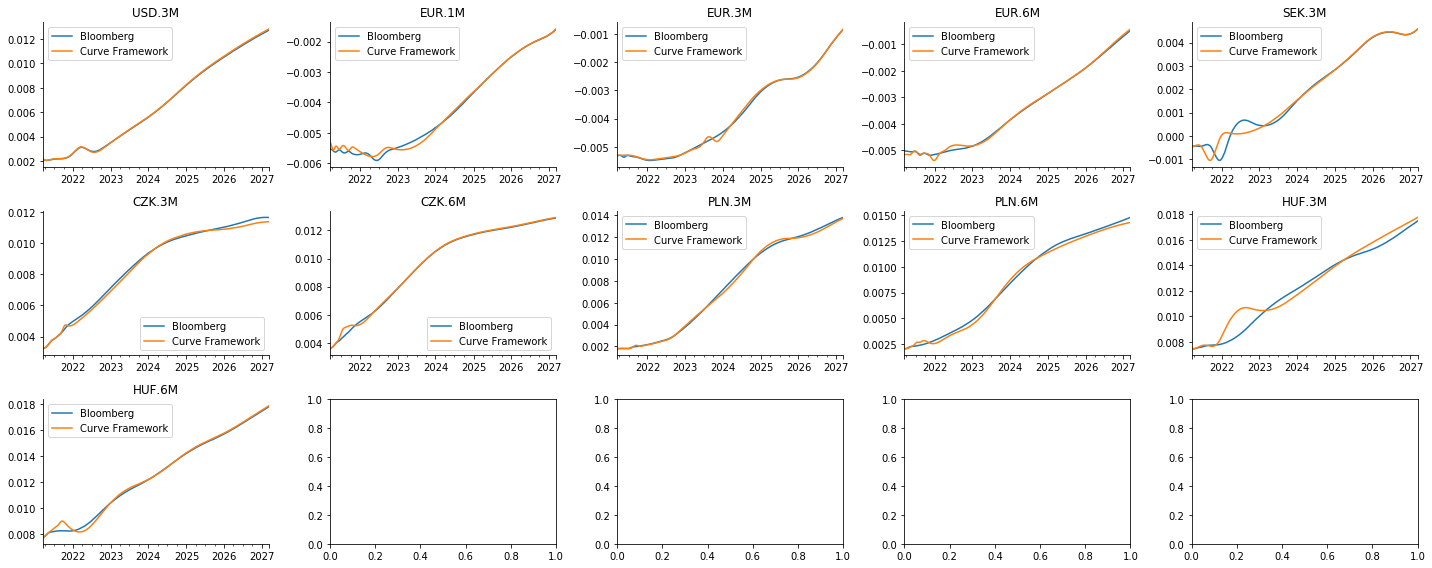

In [5]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3, 5, figsize=(20,8))
ax = ax.flatten()

def getFwd(dt):
    tenor = ticker[4:]
    start = ql.Date(str(dt)[:10], '%Y-%m-%d')
    return crv.forwardRate(start, start + ql.Period(tenor), ql.Actual360(), ql.Compounded).rate()

for idx, ticker in enumerate(fwds.columns):
    res = pd.DataFrame(fwds[ticker]) / 100
    res.columns = ['Bloomberg']
    crv = curves.get(ticker)
    res['Curve Framework'] = [*map(lambda x: getFwd(x), res.index)]
    res.plot(ax=ax[idx])
    ax[idx].set_title(ticker)
    ax[idx].spines['top'].set_visible(False)
    ax[idx].spines['right'].set_visible(False)
plt.tight_layout()

### FRA

`ql.ForwardRateAgreement(valueDate, maturityDate, position, strikeForward, notional, iborIndex, discountCurve)`

In [7]:
# 3mlibor, 3meuribor, 6meuribor, 6mLibor, 1MLibor, 3mStibor,  6mPribor, 3mwibor, 1meuribor, 3mBubor, , 6mWibor, 3mPribor, 6mbubor
indexes = ['USD.1M', 'USD.3M', 'USD.6M', 'EUR.1M', 'EUR.3M', 'EUR.6M',  'SEK.3M', 'CZK.3M', 'CZK.6M', 'PLN.3M',  'PLN.6M', 'HUF.3M', 'HUF.6M']

# Missing 1yEuribor, 3moibor,

def makeFra(ticker, start, end, notional = 10e6):
    yts = ql.YieldTermStructureHandle(curves.get(ticker))
    index = objects.get(ticker).clone(yts)    
    return ql.ForwardRateAgreement(
        start,
        end,
        ql.Position.Short,
        0.01,
        notional,
        index,
        yts
    )

In [8]:
dates = ql.MakeSchedule(ql.Date(15,6,2021), ql.Date(15,6,2024), ql.Period('6M'))
rates = pd.DataFrame(columns=dates)

for index in indexes:
    for dt in dates:        
        fra = makeFra(index, dt, dt + ql.Period('6M'))
        rates.loc[index, dt] = fra.forwardRate().rate()
rates.style.format("{:.2%}")

,"June 15th, 2021","December 15th, 2021","June 15th, 2022","December 15th, 2022","June 15th, 2023","December 15th, 2023","June 15th, 2024"
USD.1M,0.16%,0.16%,0.18%,0.22%,0.29%,0.40%,0.53%
USD.3M,0.21%,0.25%,0.28%,0.34%,0.45%,0.55%,0.67%
USD.6M,0.25%,0.32%,0.49%,0.52%,0.60%,0.73%,0.87%
EUR.1M,-0.56%,-0.56%,-0.58%,-0.56%,-0.55%,-0.50%,-0.43%
EUR.3M,-0.53%,-0.54%,-0.54%,-0.53%,-0.49%,-0.47%,-0.38%
EUR.6M,-0.50%,-0.54%,-0.48%,-0.48%,-0.46%,-0.39%,-0.34%
SEK.3M,-0.04%,-0.01%,0.01%,0.03%,0.08%,0.15%,0.21%
CZK.3M,0.38%,0.47%,0.56%,0.68%,0.80%,0.92%,1.00%
CZK.6M,0.44%,0.53%,0.64%,0.78%,0.91%,1.04%,1.12%
PLN.3M,0.18%,0.21%,0.26%,0.38%,0.53%,0.68%,0.86%
